# Makemore

Noted, Coded, and Created by Han Summer 2024. Part of The 20th Summer Project

------------
### Makemore

Making more things from the data given to the model.

Under the hood, **makemore is character level language model**, it means treating every single line example of data from the training set as a sequence of individual characters.

Character level language model, simpelnya cuman prediksi huruf yang selanjutnya berdasarkan sequence huruf yang udah ada (before it)

# Makemore + Attention is All You Need

Full Indonesian Language

[Attention is All You Need](https://arxiv.org/abs/1706.03762)

**The Transformers**

**GPT -> Generative Pre-trained Transformers**

Jadi, si GPT nge-model urutan kata/karakter/huruf atau yang lebih tepatnya token, terus dia bisa ngurutin bagaimana urutan tiap token/kata di dalam sebuah rangkaian (kayak kalimat yang buat)

Jadi, di ChatGPT, si model kerjaannya cuman ngelanjutin sequence dari prompt yang dikasih sebagai outputnya

Nah ChatGPT ini bisa kerja berdasarkan paper Transformers (Attention is All You Need [2017]) yang bisa dibilang revolutioner

Awalnya si transformers ini dibuat untuk kerjaan translate kayak google translate, tapi ya ga sengaja tiba tiba bagus buat yang lain

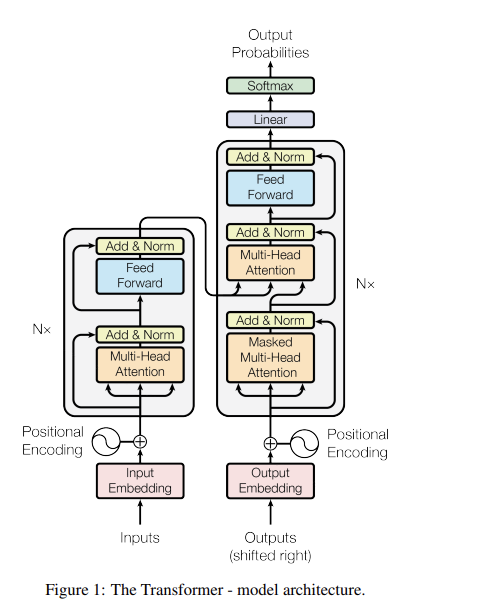

Arsitektur yang diatas ini bisa di ubah tipis tipis bisa punya banyak implementasi/fungsi

Di sini kita coba implementasi GPT ke makemore. Gamungkin dong reproduce ChatGPT modelnya sangat cape dibuat bagi seorang diri saya

## Characters level Language model - Makemore with Transformers

NANO-GPT

### Dataset

tiny shake speare (1mb)

Dataset ini dipake untuk training supaya model gimana urutan tiap karakter berdasarkan konteks dari sebelumnya

In [4]:
with open('tinyshakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
#Length of char in dataset
len(text)

1115394

In [6]:
#First 1000 char
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



Vocabulary

In [7]:
#Ambil semua karakter unik dalam dataset
chars=sorted(list(set(text)))
vocab_size=len(chars)
print("".join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


### Tokenizer

Ngubah token jadi sebuah integer, karena mesin kan ga ngerti huruf jadi kita coba convert supaya mesin ngerti

Di sini kita coba karakter/huruf sebagai token

In [8]:
#Buat tabel untuk mapping karakter ke integer dan sebaliknya
stoi={ch:i for i,ch in enumerate(chars)}
itos={i:ch for i,ch in enumerate(chars)}
#Encode (string->char to int)
encode=lambda s: [stoi[ch] for ch in s]
#Decode (int->char to string)
decode=lambda l: "".join([itos[i] for i in l])

In [9]:
print(encode("hello"))

[46, 43, 50, 50, 53]


In [10]:
print(decode([46, 43, 50, 50, 53]))

hello


In [11]:
print(decode(encode('hello')))

hello


Itu adalah contoh tokenizer sederhana. Ada implementasi lain yang lebih kompleks kayak google-sentencepiece dan OpenAI-TikToken (sub-word tokenizer), vocab lengthnya pasti lebih gede

**Encoding all dataset**

In [12]:
import torch
data=torch.tensor(encode(text),dtype=torch.long)
data.shape, data.dtype

(torch.Size([1115394]), torch.int64)

In [13]:
#First 1000 char encoded, semua huruf/kata di dataset diubah menjadi kumpulan angka int di dataset
print(data[:1000])

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57,  1, 47, 57,  1, 41, 

### Train-Val Split

In [14]:
#Misahin data menjadi train set dan validation set, supaya model bisa belajar dan diuji, kemudian kita bisa cek ga ada overfitting, ga nginget dataset doang
n= int(0.9*len(data))
train_data=data[:n]
val_data=data[n:]

### Prepare data

Sekarang saatnya kita persiapkan data buat training ke arsitektur transformersnya. Tapi ga langsung 1 data gede dicemplungin buat training, terlalu berat dan kemahalan. Jadi, kita bakal ambil beberapa bagian (chunks) random di datasetnya

In [15]:
#Chunks/Context length, panjang dari input sequence
block_size=8
#Contoh simple 1 chunk = 8 char + 1
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

berarti disini bakal begini
input 18 berarti nextnya mungkin 47

18,47 berarti nextnya mungkin 56

18,47,56 berarti nextnya mungkin 57

dan seterusnya

In [16]:
#Membuat input dan target dari dataset (y bakal offset 1 kali dari x)
x=train_data[:block_size]
y=train_data[1:block_size+1]
for t in range(block_size):
    context=x[:t+1]
    target=y[t]
    print(f"Saat input {context}, target adalah {target}")

Saat input tensor([18]), target adalah 47
Saat input tensor([18, 47]), target adalah 56
Saat input tensor([18, 47, 56]), target adalah 57
Saat input tensor([18, 47, 56, 57]), target adalah 58
Saat input tensor([18, 47, 56, 57, 58]), target adalah 1
Saat input tensor([18, 47, 56, 57, 58,  1]), target adalah 15
Saat input tensor([18, 47, 56, 57, 58,  1, 15]), target adalah 47
Saat input tensor([18, 47, 56, 57, 58,  1, 15, 47]), target adalah 58


Sistem kayak gini diperlukan supaya efisien dan transformers juga ngerti konteks 1 karakter aja sampai block size (8 karakter) untuk prediksi next character

Terus selain chunk, kita bakal buat batches supaya manfaatin GPU dan bisa pararel

In [17]:
torch.manual_seed(1337) #Supaya kelakuan randomnya sama
batch_size=4 #Banyaknya sequence yang diproses dalam satu batch dan secara paralel
block_size=8 #Panjang maksimal dari input sequence/konteks

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data # milih split train atau val
    ix = torch.randint(len(data) - block_size, (batch_size,)) # generate random index positions, generate angka random 0 sampai len(data) - block_size sebanyak batch_sizenya, buat offset di training set
    x = torch.stack([data[i:i+block_size] for i in ix]) # index ke i sampai i+block_size, ini inputnya, i itu angka yg ada di array ix
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])# targetnya adalah x yang di offset 1
    #torch.stack itu buat numpuk tensor-tensor 1D terus di tumpuk semua (stack them up at rows)
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [18]:
xb #input into transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])

In [19]:
yb #Label to transformer

tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])

### Bigram Lang Model

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1337)

class Bigram(nn.Module):
    def __init__(self,vocab_size):
        super().__init__()
        # setiap token secara langsung baca logits buat next token dari lookup table
        self.token_embedding=nn.Embedding(vocab_size, vocab_size) #vocab_size x vocab_size
        
    def forward(self,idx,target=None):
        
        #idx di pass dan bakal baca di embedding table yang di init dan ambil baris yang sesuai dgn idx
        #idx =43 bakal baca baris ke 43 dari embedding table
        logits=self.token_embedding(idx)
        # print(logits.shape)
        if target==None: #Prediction mode
            loss=None
        else:
            B,T,C = logits.shape #Batch, Time, Channel
            #targets itu B x T, kita flatten jadi 1D
            logits=logits.view(B*T,C) #Reshape to 2D supaya cross_entropy kerjanya bener
            target=target.view(B*T)
            #Loss function bakal ngebandingin logits dengan target
            loss=F.cross_entropy(logits,target) #Negative log likelihood (see makemore bigram series)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx adlaah (B x T) tensor dari konteks saat ini
        for _ in range(max_new_tokens):
            # forward pass
            logits,loss=self(idx) #Call object dirinya sendiri (forward)
            # ambil idx paling belakang dari T, karena ini adalah prediksi untuk token selanjutnya
            logits = logits[:, -1, :] # becomes (B, C)
            # pasang softmax untuk mendapatkan distribusi probabilitas
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample prediksi dari distribusi probabilitas
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # pasang idx_next yang di prediksi ke sequence yang udah ada buat ngulang lg
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
            

In [21]:
yb.shape

torch.Size([4, 8])

In [22]:
m = Bigram(vocab_size)
out, loss = m(xb, yb)
print(loss), out.shape

tensor(4.8786, grad_fn=<NllLossBackward0>)


(None, torch.Size([32, 65]))

Loss initial kurang bagus

Harusnya init pertama karena probabilitasnya rata semua seharusnya peluang tiap karakter adalah 1/65

Jadi lossnya -ln(1/65)= 4.1743..., jadi initnya ga terlalu uniform

In [23]:
start_idx=torch.zeros((1,1),dtype=torch.long)

predict=m.generate(start_idx, max_new_tokens=100)[0].tolist() #First dimension/firstbatch for predicition
print(decode(predict))


Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


Masih garbage, belum di training. Masih random weightnya

In [24]:
#Optimizer object untuk training
optimizer=torch.optim.AdamW(m.parameters(),lr=1e-3) #AdamW optimizer object

In [25]:
#Training loop
batch_size=32
for steps in range(10000):
    xb,yb=get_batch('train')
    
    #Loss eval
    logits,loss=m(xb,yb)
    optimizer.zero_grad(set_to_none=True) #Reset gradient
    loss.backward()
    optimizer.step()
    
    if steps%100==0:
        print(f"Step {steps}, Loss: {loss.item()}")

Step 0, Loss: 4.704006195068359
Step 100, Loss: 4.658433437347412
Step 200, Loss: 4.47017240524292
Step 300, Loss: 4.320702075958252
Step 400, Loss: 4.252743721008301
Step 500, Loss: 4.241008758544922
Step 600, Loss: 4.161406517028809
Step 700, Loss: 4.044336795806885
Step 800, Loss: 4.091874122619629
Step 900, Loss: 3.7458465099334717
Step 1000, Loss: 3.7031264305114746
Step 1100, Loss: 3.7115283012390137
Step 1200, Loss: 3.6330997943878174
Step 1300, Loss: 3.422212600708008
Step 1400, Loss: 3.429544687271118
Step 1500, Loss: 3.4233598709106445
Step 1600, Loss: 3.3018524646759033
Step 1700, Loss: 3.283510446548462
Step 1800, Loss: 3.188281536102295
Step 1900, Loss: 3.2000553607940674
Step 2000, Loss: 3.1371781826019287
Step 2100, Loss: 3.0028276443481445
Step 2200, Loss: 3.058077812194824
Step 2300, Loss: 2.958632707595825
Step 2400, Loss: 2.9813663959503174
Step 2500, Loss: 2.9196817874908447
Step 2600, Loss: 2.8414011001586914
Step 2700, Loss: 2.8905835151672363
Step 2800, Loss: 2.9

Predicition after training

In [26]:
start_idx=torch.zeros((1,1),dtype=torch.long)

predict=m.generate(start_idx, max_new_tokens=400)[0].tolist() #First dimension/firstbatch for predicition
print(decode(predict))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenou


Ya polanya udah ada cuman masih kehancuran karena model cuman ngambil 1 huruf sebelumnya sebagai konteks

### Mulai Transformers

matematika dalam self-attention 

In [27]:
torch.manual_seed(1337)
B,T,C = 4,8,2 #Batch, Time, Channel
x = torch.randn(B,T,C) #Random tensor
x.shape

torch.Size([4, 8, 2])

Kita akan buat gimana 8 token(time) itu "ngobrol" satu sama lain. Token ini juga ngobrolnya ama token sebelumnya, gaboleh future

Gimana ngobrolnya?

1. Setiap token ke th/sekian di sebuah sequence, kita akan kalkulasi **average** dari token sebelumnya dan token saat ini

In [28]:
# x[b,t] = mean_{i<=t} x[b,i] artinya kita cuma bisa liat ke belakang, ga bisa liat ke depan
xbow = torch.zeros((B,T,C))# init x bag of words (bow)
for b in range (B): #Iterasi untuk semua batch
    for t in range(T): #Iterasi untuk semua time step (sequence)
        xprev= x[b,:t+1] # shape -> (t,C)
        xbow[b,t]=torch.mean(xprev,dim=0) #Mean token sebelum sebelumnya dan dirinya sendiri

In [29]:
#Let's see the result
x[0], xbow[0]

(tensor([[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

Jadi itu hasil rata rata dari token dirinya sendiri dan token sebelumnya

Itu masih dalam bentuk for loop yang kurang efisien, sekarang pakai matrix multiplication

Kita memanfaatkan matrix segitiga bawah, karena dengan adanya matrix ini kita bisa modif dengan cara di normalize (dibagi elementnya supaya tiap row dijumlahin hasilnya 1) buat ngitung mean di setiap row dengan tinggal pakai perkalian matrix 

In [30]:
torch.tril(torch.ones(3,3)) #Matrix yang ngebuat semua elemen diatas diagonal 0 (Segitiga bawah)

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [31]:
torch.tril(torch.ones(3,3))/torch.sum(torch.tril(torch.ones(3,3)),dim=1,keepdim=True)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

Nah jadi angka angka 0 itu bakal ngebuang informasi setelah token itu (sesuai dengan ngambil konteks dari sebelum dan dirinya sendiri)

In [32]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3)) 
a= a/torch.sum(a,dim=1,keepdim=True) #Normalisasi
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


Hasil c itu rata rata jadinya ya

Terbukti berhasil jadi kita implement ke yang tadi

In [33]:
wei=torch.tril(torch.ones(T,T)) #T
wei=wei/wei.sum(dim=1,keepdim=True)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [34]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [35]:
wei[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
wei.shape, x.shape

(torch.Size([8, 8]), torch.Size([4, 8, 2]))

In [37]:
xbow2=wei@x #(T,T) @ (B,T,C)----> (B,T,T) @ (B,T,C)

In [38]:
xbow[0], xbow2[0] #Check both are same or not

(tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

Versi 3 pake softmax, mirip kek normalisasi tadi

In [39]:
tril = torch.tril(torch.ones(T, T))

In [40]:
wei = torch.zeros((T,T)) #weight ini di init dengan 0 untuk contoh, aslinya weight ini berdasarkan data initnya, 
# terus ini akan menunjukan afinitas/hubungan antar token, token akan ngobrol 1 sama lain dan token akan nemu lebih berhubungan ke 1 token lain
wei

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [41]:
#masked_fill adalah metode yang digunakan untuk mengisi elemen-elemen tensor dengan nilai tertentu berdasarkan kondisi yang diberikan oleh tensor mask.
#Masked fill itu dipake untuk ngisi wei yang posisinya sama dengan tril yang berelemen 0 menjadi -inf 
# untuk membuat probabilitynya jadi 0 (cek graph softmax), jadi kita ga bakal make token itu (future token)
wei = wei.masked_fill(tril == 0, float('-inf')) 
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [42]:
wei = F.softmax(wei, dim=-1)
wei #Normalized via softmax

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [43]:
xbow3 = wei @ x
xbow3[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

Versi softmax ini yang menarik dan bakal digunain di dalam self attention

In [44]:
import torch
torch.arange(5)

tensor([0, 1, 2, 3, 4])

version 4: self attention
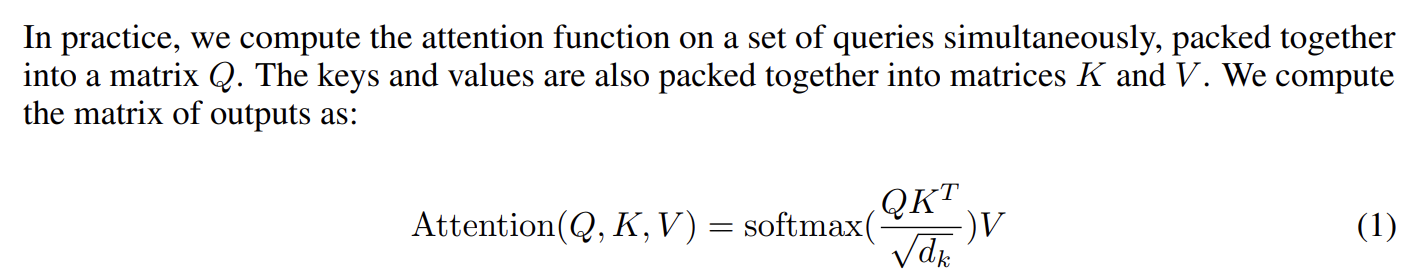

In [49]:
torch.manual_seed(1337)
B,T,C = 4,8,32
x = torch.randn(B,T,C) #Random tensor
tril = torch.tril(torch.ones(T, T)) #Lower triangular matrix for masking future tokens
# wei = torch.zeros((T,T))
#Wei harusnya ga start dari 0, tapi dari data yang ada (data dependant), 1 token bisa nemu satu token lain yang lebih berhubungan dibanding token lain
#Disini self attention kerja
# dengan cara setiap token di setiap posisi bakal ngasih 2 vektor, yaitu query ama key
# Query adalah token yang bakal nanya (What am I(token) looking for), key adalah token yang bakal jawab (what do I contain)
# Cara mengetahui hubungan antar token adalah dengan cara dot product dari query dan key. Hasilnya akan jadi wei
# Kalau key dan query aligned, hasilnya bakal besar, kalau ga aligned, hasilnya bakal kecil
# Token Query yang aligned dengan Token key akan berinteraksi lebih banyak dibanding yan ga terlalu aligned

#Single head attention
head_size=16 #The hyper-parameter
key=nn.Linear(C,head_size,bias=False) #Key vector (This is what I have)
query=nn.Linear(C,head_size,bias=False)#Query vector (This is what I am looking for -> Intereseted in)
value=nn.Linear(C,head_size,bias=False)#Value vector (If I am interesting, this is what I have to say)
k=key(x) # (B,T,head_size)
q=query(x) # (B,T,head_size) -> (B,T,16)
#Start communicating
wei=q @ k.transpose(-2,-1) # (B,T,16) @ (B,16,T) -> (B,T,T)

wei=wei.masked_fill(tril==0,float('-inf')) #Masking future tokens dengan -inf supaya probability hasil softmax 0
wei=F.softmax(wei,dim=-1)
v=value(x) # (B,T,16)
out=wei@v # (B,T,T) @ (B,T,16) -> (B,T,16)
out.shape

torch.Size([4, 8, 16])

In [48]:
wei

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.7748, 0.1427, 0.0000, 0.0000, 0.0000],
         [0.0660, 0.089

Every batch has different numbers of wei dan semua value ga uniform tergantung adjustment dari attentionnya

Note:
- Attention itu mekanisme komunikasi kayak graph ini. Di mana setiap node akan mengumpulkan informasi melalui weighted sum dari semua node yang menunjuk dirinya

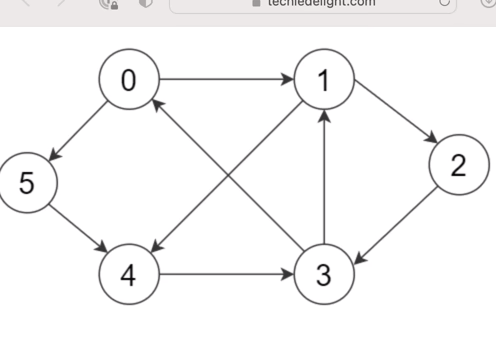

- Sistem attention juga ga punya pengetahuan tentang space. Jadi cuman set of vector aja tanpa tau posisi token di dalam space, makannya kita perlu encode posisi setiap tokennya